# Coffee Shop Simulation and Analysis

**Aloysius Brenner and Sheridan Foy**

CBE 40455: Final Project  
December 14, 2017

## Introduction

This project simulates a single day of operation for a coffee shop. Daily profits, time to complete orders, and customer satisfaction are analyzed.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import simpy
import itertools
import random
import pandas as pd
import numpy as np

## Customer Arrivals

First, we simulate customer arrivals. We first use an exponential distribution of random customer arrivals. Below, we simulate customers arriving for 100 minutes.

In [3]:
env = simpy.Environment()
log = []
customer_queue = simpy.Store(env)

T_ORDER = 5 # time to place order in minutes

def writeLog(env,orderID,stage,event):
    log.append([orderID, stage, event, env.now])

def order_generator(env,T_ORDER):
    orderID = 1
    while True:
        yield env.timeout(random.expovariate(1.0/T_ORDER))
        yield customer_queue.put(orderID)
        writeLog(env, orderID, 'Stage 0', 'Arrival')
        orderID += 1

env.process(order_generator(env,T_ORDER))
env.run(until = 100) # run simulation for 100 minutes
log

[[1, 'Stage 0', 'Arrival', 2.026491050415068],
 [2, 'Stage 0', 'Arrival', 6.50788317116818],
 [3, 'Stage 0', 'Arrival', 10.778792176602542],
 [4, 'Stage 0', 'Arrival', 12.29294306647654],
 [5, 'Stage 0', 'Arrival', 26.673436405109783],
 [6, 'Stage 0', 'Arrival', 27.46344356010164],
 [7, 'Stage 0', 'Arrival', 34.67050259965119],
 [8, 'Stage 0', 'Arrival', 41.788381283522185],
 [9, 'Stage 0', 'Arrival', 44.3903110902911],
 [10, 'Stage 0', 'Arrival', 53.6757953233911],
 [11, 'Stage 0', 'Arrival', 56.04251229033996],
 [12, 'Stage 0', 'Arrival', 86.93175981533696],
 [13, 'Stage 0', 'Arrival', 88.7934832486953],
 [14, 'Stage 0', 'Arrival', 91.21233556805488],
 [15, 'Stage 0', 'Arrival', 97.43071917003242]]

## Filling Orders

Now that the first step is completed, the second step, completing a customer order, will be simulated. For this pass,  only one drink will be served, and a uniform customer ordering density will be used. 

A single day will last 12 hours, or 720 minutes. Three servers will be available to run either the cash register, to receive the order, or the coffee maker, to make the order. Servers may also need to clean tables, as 95% of customers will sit down at a table after receiving their order.

In [4]:
class coffee_shop(object):
    
    def __init__(self,N_SERVERS=3,N_REGISTERS=1,N_MACHINES=1,N_TABLES=3,T_ORDER=2):
        self.env = simpy.Environment()
        self.log = []
        self.server = simpy.Resource(self.env,N_SERVERS)   # server resources
        self.register = simpy.Resource(self.env,N_REGISTERS) # cash register resources
        self.machine = simpy.Resource(self.env,N_MACHINES) # coffee maker resources
        self.table = simpy.Resource(self.env,N_TABLES)
        self.T_ORDER = T_ORDER
        
        self.data = dict()
        self.orderQueue = pd.Series([0],[0])               # track orders in progress
        self.env.process(self.orderGenerator())            # where to start the model
        
    def writeLog(self,orderID,stage,event):
        self.log.append([orderID, stage, event, self.env.now])
        
    def orderGenerator(self):
        orderID = 1
        while True:
            yield self.env.timeout(random.expovariate(1.0/self.T_ORDER))
            self.writeLog(orderID, 'Stage 0', 'Arrival')
            self.env.process(self.order(orderID))
            orderID += 1
            
    def writeOrderQueue(self,inc):                         # track orders in progress
        self.orderQueue[self.env.now] = self.orderQueue.iloc[-1] + inc

    def order(self,orderID):
        # request cash register to take order
        with self.register.request() as registerreq:
            yield registerreq
            # request server to take order from customer
            with self.server.request() as serverreq:
                yield serverreq
                self.writeLog(orderID,'Stage 1', 'Order')
                self.writeOrderQueue(+1)
                yield self.env.timeout(0.75)
        
        # request machine to make drink
        with self.machine.request() as machinereq:
            yield machinereq
            # request server to make drink
            with self.server.request() as serverreq:
                yield serverreq
                yield self.env.timeout(1.5)
                self.writeLog(orderID,'Stage 2', 'Make Order') 
            # request server to give order to customer
            with self.server.request() as serverreq:
                yield serverreq
                yield self.env.timeout(0.25)
                self.writeLog(orderID,'Stage 3', 'Finish Order')
        
        # request table to seat customer
        needtable = random.random()
        if needtable < 0.95:
            with self.table.request() as tablereq:
                yield tablereq
                self.writeLog(orderID,'Stage 4', 'Customer Seated')
                self.writeOrderQueue(-1)
                yield self.env.timeout(5)
            # request server to clean table
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(1)
                    self.writeLog(orderID,'Stage 5', 'Table Cleaned')
        else:
            self.writeLog(orderID,'Stage 4', 'Customer Served')
            self.writeOrderQueue(-1)
            
    def processLog(self):
        df = pd.DataFrame([[a,b,c,t] for (a,b,c,t) in self.log])
        df = df.pivot(index=0,columns=1,values=3).reset_index()
        df = df.set_index([0]).dropna()
        df.index.rename('OrderID',inplace=True)

        stage1 = df['Stage 1']-df['Stage 0']
        stage2 = df['Stage 2']-df['Stage 1']
        stage3 = df['Stage 3']-df['Stage 2']
        stage4 = df['Stage 4']-df['Stage 3']
        stage5 = df['Stage 5']-df['Stage 4']
        totaltime = df['Stage 4']-df['Stage 0']

        print('Mean Order Completion = {0:6.1f} min.\n'.format((df['Stage 4'] - df['Stage 0']).mean()))

        print('Mean Time in Process Stages:\n')
        print('           Order Queue = {0:6.1f} min.'.format(stage1.mean()))
        print('          Order Making = {0:6.1f} min.'.format(stage2.mean()))
        print('       Order Finishing = {0:6.1f} min.'.format(stage3.mean()))
        print('      Customer Seating = {0:6.1f} min.'.format(stage4.mean()))
        print('        Table Cleaning = {0:6.1f} min.'.format(stage5.mean()))
    
        totaltime.hist(bins=30)
        plt.title('Distribution of Customer Wait Times')
        plt.ylabel('Count')
        plt.xlabel('Minutes')        
                    
    def run(self,t_sim):
        self.env.run(until=t_sim)

The average time to complete each stage and the distribution of customer wait times are displayed below. 

Mean Order Completion =    5.2 min.

Mean Time in Process Stages:

           Order Queue =    0.2 min.
          Order Making =    2.3 min.
       Order Finishing =    0.3 min.
      Customer Seating =    2.4 min.
        Table Cleaning =    6.0 min.


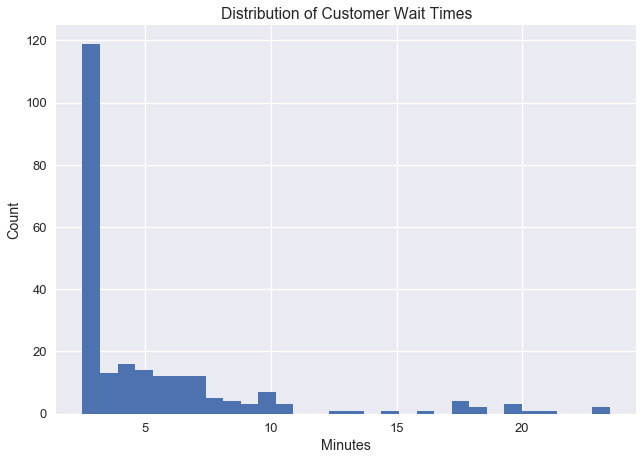

In [5]:
r = coffee_shop(3,1,2,3,3) # servers, registers, coffee machines, tables, order time
r.run(720)
r.log
r.processLog()

The most common customer wait time is 2.5 minutes, which is the minimum time it takes to complete a customer order. This would make sense in a coffee shop, since orders are generally completed quickly with a few orders taking longer due to back-ups. 

## Add Menu

Next, we create our menu with several drink options: black coffee, espresso shot, and latte. These drinks take different times to make, and two different machines are used to make these drinks. 

In [6]:
menu = {
    'black coffee': {'probability': 0.3, 'prep time': 0.5, 'profit': 2.0, 'machine':'coffee maker'},
    'espresso shot': {'probability': 0.1, 'prep time': 1.5, 'profit': 1.5, 'machine':'espresso maker'},
    'latte': {'probability': 0.6, 'prep time': 3.0, 'profit': 3.0, 'machine':'espresso maker'}
}
menu = pd.DataFrame(menu)

items = menu.columns
probs = pd.to_numeric(menu.loc['probability',:])

menu


,black coffee,espresso shot,latte
machine,coffee maker,espresso maker,espresso maker
prep time,0.5,1.5,3
probability,0.3,0.1,0.6
profit,2,1.5,3


In [7]:
class coffee_shop(object):
    
    def __init__(self,N_SERVERS=3,N_REGISTERS=1,N_COFFEEMAKERS=1,N_ESPMAKERS=1,N_TABLES=3,T_ORDER=2):
        self.env = simpy.Environment()
        self.log = []
        self.server = simpy.Resource(self.env,N_SERVERS)      # server resources
        self.register = simpy.Resource(self.env,N_REGISTERS)  # cash register resources
        self.coffee = simpy.Resource(self.env,N_COFFEEMAKERS) # coffee maker resources
        self.espresso = simpy.Resource(self.env,N_ESPMAKERS)   # espresso maker resources
        self.table = simpy.Resource(self.env,N_TABLES)
        self.T_ORDER = T_ORDER
        
        self.data = dict()
        self.orderQueue = pd.Series([0],[0])               # track orders in progress
        self.env.process(self.orderGenerator())            # where to start the model
        
    def writeLog(self,orderID,item,stage,event):
        self.log.append([orderID, item, stage, event, self.env.now])
        
    def orderGenerator(self):
        orderID = 1
        while True:
            yield self.env.timeout(random.expovariate(1.0/self.T_ORDER))
            item = np.random.choice(items,p=probs)
            self.writeLog(orderID, item, 'Stage 0', 'Arrival')
            self.env.process(self.order(orderID, item))
            orderID += 1
            
    def writeOrderQueue(self,inc):                         # track orders in progress
        self.orderQueue[self.env.now] = self.orderQueue.iloc[-1] + inc

    def order(self,orderID,item):
        # request cash register to take order
        with self.register.request() as registerreq:
            yield registerreq
            # request server to take order from customer
            with self.server.request() as serverreq:
                yield serverreq
                self.writeLog(orderID,item,'Stage 1', 'Order')
                self.writeOrderQueue(+1)
                yield self.env.timeout(0.75)
        
        # request machine to make drink
        if menu[item]['machine'] == 'coffee maker':
            with self.coffee.request() as machinereq:
                yield machinereq
                # request server to make drink
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(menu[item]['prep time'])
                    self.writeLog(orderID, item, 'Stage 2', 'Make Order') 
                # request server to give order to customer
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(0.25)
                    self.writeLog(orderID, item, 'Stage 3', 'Finish Order')
        else:
            with self.espresso.request() as machinereq:
                yield machinereq
                # request server to make drink
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(menu[item]['prep time'])
                    self.writeLog(orderID, item, 'Stage 2', 'Make Order') 
                # request server to give order to customer
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(0.25)
                    self.writeLog(orderID, item, 'Stage 3', 'Finish Order')
        
        # request table to seat customer
        needtable = random.random()
        if needtable < 0.4:
            with self.table.request() as tablereq:
                yield tablereq
                self.writeLog(orderID,item, 'Stage 4', 'Customer Seated')
                self.writeOrderQueue(-1)
                yield self.env.timeout(5)
            # request server to clean table
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(1)
                    self.writeLog(orderID, item,'Stage 5', 'Table Cleaned')
        else:
            self.writeLog(orderID,item,'Stage 4', 'Customer Served')
            self.writeOrderQueue(-1)
            
    def processLog(self):
        df = pd.DataFrame([[a,b,c,d,t] for (a,b,c,d,t) in self.log])
        df = df.pivot(index=0,columns=2,values=4).reset_index()
        df = df.set_index([0]).dropna()
        df.index.rename('OrderID',inplace=True)

        stage1 = df['Stage 1']-df['Stage 0']
        stage2 = df['Stage 2']-df['Stage 1']
        stage3 = df['Stage 3']-df['Stage 2']
        stage4 = df['Stage 4']-df['Stage 3']
        stage5 = df['Stage 5']-df['Stage 4']
        totaltime = df['Stage 4']-df['Stage 0']

        print('Mean Order Completion = {0:6.1f} min.\n'.format((df['Stage 4'] - df['Stage 0']).mean()))

        print('Mean Time in Process Stages:\n')
        print('           Order Queue = {0:6.1f} min.'.format(stage1.mean()))
        print('          Order Making = {0:6.1f} min.'.format(stage2.mean()))
        print('       Order Finishing = {0:6.1f} min.'.format(stage3.mean()))
        print('      Customer Seating = {0:6.1f} min.'.format(stage4.mean()))
        print('        Table Cleaning = {0:6.1f} min.'.format(stage5.mean()))
    
        totaltime.hist(bins=30)
        plt.title('Distribution of Customer Wait Times')
        plt.ylabel('Count')
        plt.xlabel('Time to Complete Order (Minutes)')        
                    
    def run(self,t_sim):
        self.env.run(until=t_sim)

Mean Order Completion =    3.7 min.

Mean Time in Process Stages:

           Order Queue =    0.2 min.
          Order Making =    3.2 min.
       Order Finishing =    0.3 min.
      Customer Seating =    0.0 min.
        Table Cleaning =    6.0 min.


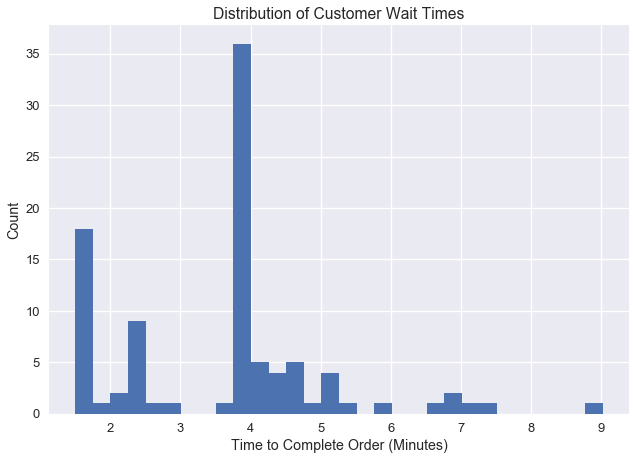

In [8]:
r = coffee_shop(3,1,2,2,3,3) # servers, registers, coffee machines, espresso machines, tables, order time
r.run(720)
r.log
r.processLog()

Now with different make order times, there is more variance in the customer wait times. 

## Add Complexity to Customer Arrival Times

Now we implement the idea that at certain times, customers are more likely to arrive. If the coffee shop opens at 8:00 AM and closes at 8:00 PM, and 8:00AM is designated minute 0, then the following "busy times" are designated as shown below.

9AM-10AM: minutes 60-120

12PM-1PM: minutes 240-300

In [9]:
class coffee_shop(object):
    
    def __init__(self,N_SERVERS=3,N_REGISTERS=1,N_COFFEEMAKERS=1,N_ESPMAKERS=1,N_TABLES=3,T_ORDER=2):
        self.env = simpy.Environment()
        self.log = []
        self.dailyprofit = 0.0
        self.server = simpy.Resource(self.env,N_SERVERS)      # server resources
        self.register = simpy.Resource(self.env,N_REGISTERS)  # cash register resources
        self.coffee = simpy.Resource(self.env,N_COFFEEMAKERS) # coffee maker resources
        self.espresso = simpy.Resource(self.env,N_ESPMAKERS)   # espresso maker resources
        self.table = simpy.Resource(self.env,N_TABLES)
        self.T_ORDER = T_ORDER
        
        self.data = dict()
        self.orderQueue = pd.Series([0],[0])               # track orders in progress
        self.env.process(self.orderGenerator())            # where to start the model
        
    def writeLog(self,orderID,item,stage,event):
        self.log.append([orderID, item, stage, event, self.env.now])
        
    def orderGenerator(self):
        orderID = 1
        while True:
            # Customers arrive faster between 9-10AM and 12-1PM
            if (60<=self.env.now<=120) or (240<=self.env.now<=300):  
                yield self.env.timeout(random.expovariate(2.5/self.T_ORDER)) 
            else: 
                yield self.env.timeout(random.expovariate(1.0/self.T_ORDER))
            item = np.random.choice(items,p=probs)
            self.writeLog(orderID, item, 'Stage 0', 'Arrival')
            self.env.process(self.order(orderID, item))
            orderID += 1
            
    def writeOrderQueue(self,inc):                         # track orders in progress
        self.orderQueue[self.env.now] = self.orderQueue.iloc[-1] + inc

    def order(self,orderID,item):
        # request cash register to take order
        with self.register.request() as registerreq:
            yield registerreq
            # request server to take order from customer
            with self.server.request() as serverreq:
                yield serverreq
                self.writeLog(orderID,item,'Stage 1', 'Order')
                self.writeOrderQueue(+1)
                yield self.env.timeout(0.75)
        
        # request machine to make drink
        if menu[item]['machine'] == 'coffee maker':
            with self.coffee.request() as machinereq:
                yield machinereq
                # request server to make drink
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(menu[item]['prep time'])
                    self.writeLog(orderID, item, 'Stage 2', 'Make Order') 
                # request server to give order to customer
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(0.25)
                    self.writeLog(orderID, item, 'Stage 3', 'Finish Order')
        else:
            with self.espresso.request() as machinereq:
                yield machinereq
                # request server to make drink
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(menu[item]['prep time'])
                    self.writeLog(orderID, item, 'Stage 2', 'Make Order') 
                # request server to give order to customer
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(0.25)
                    self.writeLog(orderID, item, 'Stage 3', 'Finish Order')
                    self.dailyprofit += menu[item]['profit']
        
        # request table to seat customer
        needtable = random.random()
        if needtable < 0.4:
            with self.table.request() as tablereq:
                yield tablereq
                self.writeLog(orderID,item, 'Stage 4', 'Customer Seated')
                self.writeOrderQueue(-1)
                yield self.env.timeout(5)
            # request server to clean table
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(1)
                    self.writeLog(orderID, item,'Stage 5', 'Table Cleaned')
        else:
            self.writeLog(orderID,item,'Stage 4', 'Customer Served')
            self.writeOrderQueue(-1)
            
    def processLog(self):
        df = pd.DataFrame([[a,b,c,d,t] for (a,b,c,d,t) in self.log])
        df = df.pivot(index=0,columns=2,values=4).reset_index()
        df = df.set_index([0]).dropna()
        df.index.rename('OrderID',inplace=True)

        stage1 = df['Stage 1']-df['Stage 0']
        stage2 = df['Stage 2']-df['Stage 1']
        stage3 = df['Stage 3']-df['Stage 2']
        stage4 = df['Stage 4']-df['Stage 3']
        stage5 = df['Stage 5']-df['Stage 4']
        totaltime = df['Stage 4']-df['Stage 0']
        time = df['Stage 0']

        print('Mean Order Completion = {0:6.1f} min.\n'.format((df['Stage 4'] - df['Stage 0']).mean()))

        print('Mean Time in Process Stages:\n')
        print('           Order Queue = {0:6.1f} min.'.format(stage1.mean()))
        print('          Order Making = {0:6.1f} min.'.format(stage2.mean()))
        print('       Order Finishing = {0:6.1f} min.'.format(stage3.mean()))
        print('      Customer Seating = {0:6.1f} min.'.format(stage4.mean()))
        print('        Table Cleaning = {0:6.1f} min.'.format(stage5.mean()))
    
        plt.figure(1)
        plt.subplot(212)
        time.hist(bins=12)
        plt.title('Customer Arrivals')
        plt.ylabel('Count')
        plt.xlabel('Time (minutes)') 
    
        plt.figure(2)
        plt.subplot(211)
        totaltime.hist(bins=30)
        plt.title('Distribution of Customer Wait Times')
        plt.ylabel('Count')
        plt.xlabel('Time to Complete Order (Minutes)')  
                    
    def run(self,t_sim):
        self.env.run(until=t_sim)

An additional graph will display the distribution of customer arrivals. 

Mean Order Completion =    5.0 min.

Mean Time in Process Stages:

           Order Queue =    1.8 min.
          Order Making =    2.9 min.
       Order Finishing =    0.3 min.
      Customer Seating =    0.0 min.
        Table Cleaning =    6.1 min.


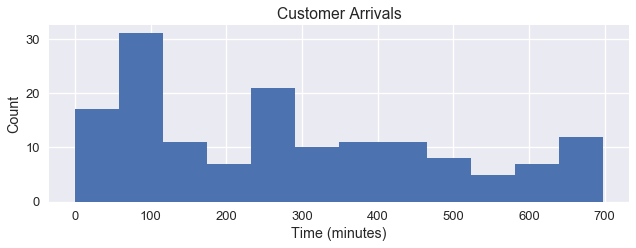

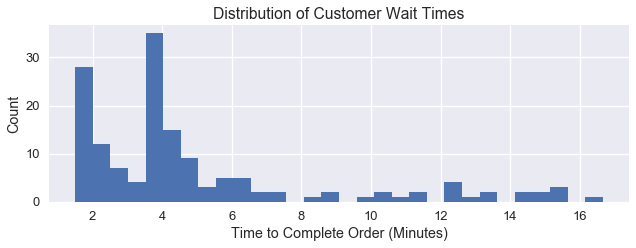

In [10]:
N_SERVERS = 4;
hoursopen = 12;

r = coffee_shop(N_SERVERS,1,3,3,5,2.5) # servers, registers, coffee machines, espresso machines, tables, order time
r.run(hoursopen*60)
r.log
r.processLog()

## Implement Daily Profit and Customer Satisfaction

Now we can analyze the daily profit and customer satisfaction. We use the following functions to calculate these:

Profit = Profit from Items Sold - Daily Wages - Other Operating Costs

where  
$$Other Operating Costs = \frac{Monthly Rent}{30 days} + \frac{(MachineCost)(NumberofMachines)}{LifetimeInWorkdays}$$
$$Other Operating Costs = \frac{1000}{30} + \frac{(4500)(4)}{260*10} = $40$$

Customer Satisfaction:
$$S(t) = 100*exp(-t/5)$$

where S(t) is customer satisfaction, and t is the time to complete a customer's order.

Our goals are to turn a profit while maintaining an average customer satisfaction of at least 50±5%.

In [11]:
class coffee_shop(object):
    
    def __init__(self,N_SERVERS=3,N_REGISTERS=1,N_COFFEEMAKERS=1,N_ESPMAKERS=1,N_TABLES=3,T_ORDER=2):
        self.env = simpy.Environment()
        self.log = []
        self.dailyprofit = 0.0
        self.server = simpy.Resource(self.env,N_SERVERS)      # server resources
        self.register = simpy.Resource(self.env,N_REGISTERS)  # cash register resources
        self.coffee = simpy.Resource(self.env,N_COFFEEMAKERS) # coffee maker resources
        self.espresso = simpy.Resource(self.env,N_ESPMAKERS)   # espresso maker resources
        self.table = simpy.Resource(self.env,N_TABLES)
        self.T_ORDER = T_ORDER
        
        self.data = dict()
        self.orderQueue = pd.Series([0],[0])               # track orders in progress
        self.env.process(self.orderGenerator())            # where to start the model
        
    def writeLog(self,orderID,item,stage,event):
        self.log.append([orderID, item, stage, event, self.env.now])
        
    def orderGenerator(self):
        orderID = 1
        while True:
            # Customers arrive faster between 9-10AM and 12-1PM
            if (60<=self.env.now<=120) or (240<=self.env.now<=300):  
                yield self.env.timeout(random.expovariate(2.5/self.T_ORDER)) 
            else: 
                yield self.env.timeout(random.expovariate(1.0/self.T_ORDER))
            item = np.random.choice(items,p=probs)
            self.writeLog(orderID, item, 'Stage 0', 'Arrival')
            self.env.process(self.order(orderID, item))
            orderID += 1
            
    def writeOrderQueue(self,inc):                         # track orders in progress
        self.orderQueue[self.env.now] = self.orderQueue.iloc[-1] + inc

    def order(self,orderID,item):
        # request cash register to take order
        with self.register.request() as registerreq:
            yield registerreq
            # request server to take order from customer
            with self.server.request() as serverreq:
                yield serverreq
                self.writeLog(orderID,item,'Stage 1', 'Order')
                self.writeOrderQueue(+1)
                yield self.env.timeout(0.75)
        
        # request machine to make drink
        if menu[item]['machine'] == 'coffee maker':
            with self.coffee.request() as machinereq:
                yield machinereq
                # request server to make drink
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(menu[item]['prep time'])
                    self.writeLog(orderID, item, 'Stage 2', 'Make Order') 
                # request server to give order to customer
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(0.25)
                    self.writeLog(orderID, item, 'Stage 3', 'Finish Order')
        else:
            with self.espresso.request() as machinereq:
                yield machinereq
                # request server to make drink
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(menu[item]['prep time'])
                    self.writeLog(orderID, item, 'Stage 2', 'Make Order') 
                # request server to give order to customer
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(0.25)
                    self.writeLog(orderID, item, 'Stage 3', 'Finish Order')
                    self.dailyprofit += menu[item]['profit']
        
        # request table to seat customer
        needtable = random.random()
        if needtable < 0.4:
            with self.table.request() as tablereq:
                yield tablereq
                self.writeLog(orderID,item, 'Stage 4', 'Customer Seated')
                self.writeOrderQueue(-1)
                yield self.env.timeout(5)
            # request server to clean table
                with self.server.request() as serverreq:
                    yield serverreq
                    yield self.env.timeout(1)
                    self.writeLog(orderID, item,'Stage 5', 'Table Cleaned')
        else:
            self.writeLog(orderID,item,'Stage 4', 'Customer Served')
            self.writeOrderQueue(-1)
            
    def processLog(self):
        df = pd.DataFrame([[a,b,c,d,t] for (a,b,c,d,t) in self.log])
        df = df.pivot(index=0,columns=2,values=4).reset_index()
        df = df.set_index([0]).dropna()
        df.index.rename('OrderID',inplace=True)

        stage1 = df['Stage 1']-df['Stage 0']
        stage2 = df['Stage 2']-df['Stage 1']
        stage3 = df['Stage 3']-df['Stage 2']
        stage4 = df['Stage 4']-df['Stage 3']
        stage5 = df['Stage 5']-df['Stage 4']
        totaltime = df['Stage 4']-df['Stage 0']
        time = df['Stage 0']
        
        S = 100*np.exp(-totaltime/5)
        
        print('Mean Order Completion = {0:6.1f} min.\n'.format((df['Stage 4'] - df['Stage 0']).mean()))

        print('Mean Time in Process Stages:\n')
        print('           Order Queue = {0:6.1f} min.'.format(stage1.mean()))
        print('          Order Making = {0:6.1f} min.'.format(stage2.mean()))
        print('       Order Finishing = {0:6.1f} min.'.format(stage3.mean()))
        print('      Customer Seating = {0:6.1f} min.'.format(stage4.mean()))
        print('        Table Cleaning = {0:6.1f} min.'.format(stage5.mean()))
    
        plt.figure(1)
        plt.subplot(212)
        time.hist(bins=12)
        plt.title('Customer Arrivals')
        plt.ylabel('Count')
        plt.xlabel('Time (minutes)') 
    
        plt.figure(2)
        plt.subplot(211)
        totaltime.hist(bins=30)
        plt.title('Distribution of Customer Wait Times')
        plt.ylabel('Count')
        plt.xlabel('Time to Complete Order (Minutes)')  
        
        plt.figure(3)
        S.plot(kind='line')
        plt.title('Customer Satisfaction')
        plt.ylabel('Satisfaction %')
        plt.xlabel('OrderID')
        
        print('Average Customer Satisfaction is ',round(np.average(S),2), '%')
                    
    def run(self,t_sim):
        self.env.run(until=t_sim)

An additional graph will display customer satisfaction for each individual customer. Over time, satisfaction is expected to decrease during busier times, since wait times increase during these periods. In the graph below, this is mostly true, customers arriving during busier times tend to have lower satisfaction levels than those that arrive during non-busy hours.

Mean Order Completion =    4.8 min.

Mean Time in Process Stages:

           Order Queue =    1.5 min.
          Order Making =    3.0 min.
       Order Finishing =    0.3 min.
      Customer Seating =    0.0 min.
        Table Cleaning =    6.1 min.
Average Customer Satisfaction is  43.97 %
Daily Profit is $ 299.0


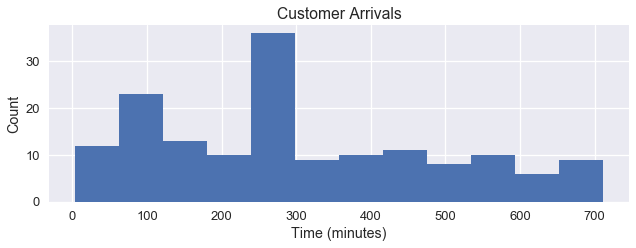

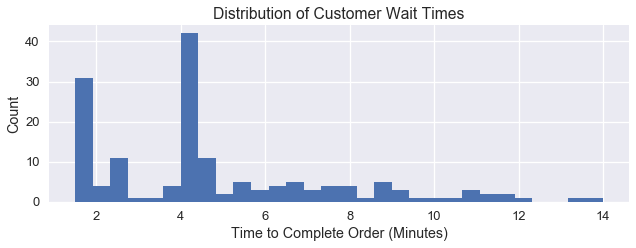

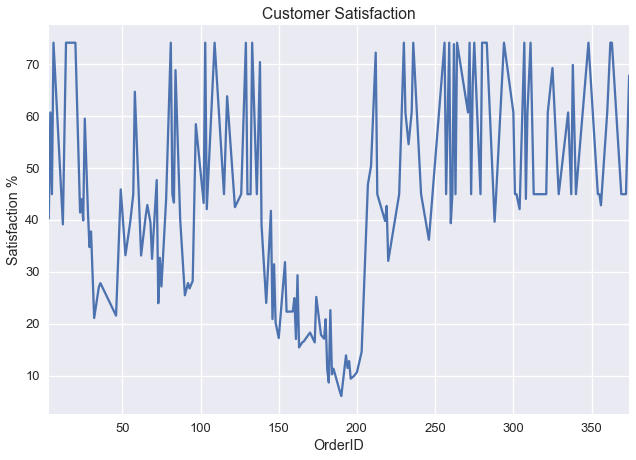

In [12]:
N_SERVERS = 4;
hoursopen = 12;

r = coffee_shop(N_SERVERS,1,3,3,5,2.5) # servers, registers, coffee machines, espresso machines, tables, order time
r.run(hoursopen*60)
r.log
r.processLog()

# Calculate Profit
profit = r.dailyprofit - N_SERVERS*hoursopen*8 - 40 
# other operating costs were determined by determining daily values for building rent and machine leasing costs

print('Daily Profit is $',profit)

Both profit and customer satisfaction is dependent on the number of servers. With higher numbers of servers, customer wait times are decreased, increasing individual satisfaction. However, this introduces a lower daily profit, as servers need to be paid hourly wages. 

After running the simulation many times to find optimal numbers of servers while maintaining our goals, we determined that four servers over the course of a 12-hour day maintained our goals of daily customer satisfaction while also turning a profit.